In [ ]:
%%html
<iframe src="https://cdn.mazda.ca/common/owners/sirius/1920x540_siriusxm_masthead_v1.ts.2102021136400000.jpg" width="100%" height="400"></iframe>

In [ ]:
!pip install pycaret

     |████████████████████████████████| 266 kB 4.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 6.8 MB 40.3 MB/s 
     |████████████████████████████████| 261 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 25.0 MB/s 
     |████████████████████████████████| 2.0 MB 51.0 MB/s 
     |████████████████████████████████| 16.9 MB 43 kB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 1.3 MB 49.6 MB/s 
     |████████████████████████████████| 113 kB 60.0 MB/s 
     |████████████████████████████████| 1.7 MB 40.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 60.9 MB/s 
     |████████████████████████████████| 10.1 MB 58.2 MB/s 
     |████████████████████████████████| 102 kB 11.8 MB/s 
     |██████████████████

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from pycaret.classification import *

In [ ]:
# df = open_excel(path,filename,'Data')
df = pd.read_csv('https://raw.githubusercontent.com/peeti-ucberkeley/siriusxm/main/Case%20Study%20-%20Agent%20Analysis%20-%20Data.csv')
df.head()

,Transaction Number,Customer ID,AgentID,Partner,Agent Start Date,Primary Skill,Saves,Sales,Time Spent on Call (Seconds),Expected Life Time Value
0,1246,91123,457896,Partner C,9/20/2019,Saves,1,0,272,201
1,918,90795,3000,Partner C,9/20/2019,Service,1,1,25,367
2,1271,91148,457896,Partner C,9/20/2019,Saves,1,0,259,128
3,915,90792,3000,Partner C,9/20/2019,Service,1,0,54,399
4,1268,91145,457896,Partner C,9/20/2019,Saves,1,0,228,136


In [ ]:
df.dtypes # check df type

Transaction Number               int64
Customer ID                      int64
AgentID                          int64
Partner                         object
Agent Start Date                object
Primary Skill                   object
Saves                            int64
Sales                            int64
Time Spent on Call (Seconds)     int64
Expected Life Time Value         int64
dtype: object

In [ ]:
def calc_date_dff(d1):
    event_occur = '09/20/2019'
    datex = datetime.strptime(event_occur, '%m/%d/%Y')
    date = datetime.strptime(d1,'%m/%d/%Y')
    day_diff = datex-date
    no_days = day_diff.days
    return no_days
    
df['Agent_Tenure'] = df['Agent Start Date'].apply(lambda x: 0 if calc_date_dff(x) >= 0 and calc_date_dff(x) < 30\
                                              else (1 if calc_date_dff(x) >= 30 and calc_date_dff(x) < 90\
                                                   else (2 if calc_date_dff(x) >= 90 else -1)))
df.head()

,Transaction Number,Customer ID,AgentID,Partner,Agent Start Date,Primary Skill,Saves,Sales,Time Spent on Call (Seconds),Expected Life Time Value,Agent_Tenure
0,1246,91123,457896,Partner C,9/20/2019,Saves,1,0,272,201,0
1,918,90795,3000,Partner C,9/20/2019,Service,1,1,25,367,0
2,1271,91148,457896,Partner C,9/20/2019,Saves,1,0,259,128,0
3,915,90792,3000,Partner C,9/20/2019,Service,1,0,54,399,0
4,1268,91145,457896,Partner C,9/20/2019,Saves,1,0,228,136,0


In [ ]:
[col for col in df.Partner.unique()] # check unique  value

['Partner C', 'Partner B', 'Partner A']

In [ ]:
[col for col in df['Primary Skill'].unique()] #check unique value

['Saves', 'Service', 'Technical Support']

Now Select for only neccessary columns

In [ ]:
save_df = df[['Partner','Primary Skill','Saves','Time Spent on Call (Seconds)','Expected Life Time Value ','Agent_Tenure']]
save_df.shape

(1346, 6)

Perform One Hot Code for categorical columns

In [ ]:
data = save_df.drop(save_df.iloc[:,:2], axis= 1)
display(data.head(1))
partner = pd.get_dummies(save_df.Partner)

# skill = pd.get_dummies(df['PrimarySkill'])
skill = pd.get_dummies(save_df['Primary Skill'])
skill = skill.rename(columns = lambda x: "skill_"+x)
skill.head()

,Saves,Time Spent on Call (Seconds),Expected Life Time Value,Agent_Tenure
0,1,272,201,0


,skill_Saves,skill_Service,skill_Technical Support
0,1,0,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0


Join one hot code columns

In [ ]:
dataset = pd.concat([data,partner,skill], axis=1)
dataset.shape

(1346, 10)

Visualize correlation metrix

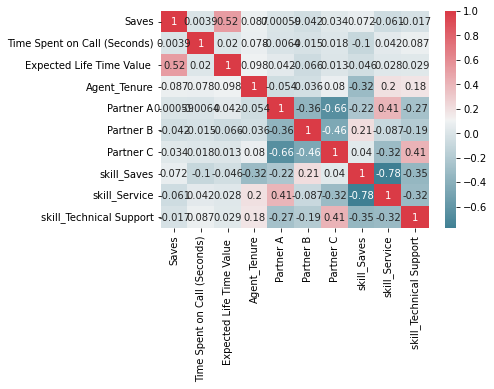

In [ ]:
corr = dataset.corr()
sns.heatmap(corr,  cmap=sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

To calculate P-Vaue, create save rate using group by  

In [ ]:
sum_save = df.groupby(by=['Primary Skill'])['Saves','Sales'].sum().reset_index()
no_call = df.groupby(by=['Primary Skill'])['Transaction Number'].count().reset_index()
summary = sum_save.merge(no_call, how='inner',on=['Primary Skill'])
# create conversion and save rate
summary['save_rate'] = (summary['Saves']/summary['Transaction Number'])*100
summary['conversion_rate'] = (summary['Sales']/summary['Transaction Number'])*100

summary = summary.drop(['Saves', 'Sales', 'Transaction Number'], axis=1)
summary

,Primary Skill,save_rate,conversion_rate
0,Saves,64.983713,49.022801
1,Service,57.624113,50.000000
2,Technical Support,58.928571,50.000000


In [ ]:
summary['Primary Skill']  = summary['Primary Skill'].apply(lambda x: 1 if x == 'Service' else (2 if x == 'Saves' else 3))
summary

,Primary Skill,save_rate,conversion_rate
0,2,64.983713,49.022801
1,1,57.624113,50.000000
2,3,58.928571,50.000000


P-VALUE for all primary skills

In [ ]:
corr_df = pd.DataFrame(columns=['Corr', 'P-Value'])

for col in summary:
    if pd.api.types.is_numeric_dtype(summary[col]):
        r, p = stats.pearsonr(summary.save_rate, summary[col])
        corr_df.loc[col] = [round(r, 3), round(p, 6)]

corr_df

,Corr,P-Value
Primary Skill,0.166,0.893774
save_rate,1.000,0.000000
conversion_rate,-0.986,0.106226


perform GLM for standard statistics

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm


In [ ]:
# remove space in the column name
df.columns = df.columns.str.replace(" ","")
df.columns = df.columns.str.replace("(","")
df.columns = df.columns.str.replace(")","")
df.columns

Index(['TransactionNumber', 'CustomerID', 'AgentID', 'Partner',
       'AgentStartDate', 'PrimarySkill', 'Saves', 'Sales',
       'TimeSpentonCallSeconds', 'ExpectedLifeTimeValue', 'Agent_Tenure'],
      dtype='object')

In [ ]:
skill = pd.get_dummies(df['PrimarySkill'])
skill = skill.rename(columns = lambda x: "skill_"+x)

df1 = df.copy()

df1 = df.iloc[:,5:]
df1 = df1.drop('Sales', axis=1) # dont need Sales
display(df1.head(1))
df1 = pd.concat([df1,skill], axis=1)
df1.columns = df1.columns.str.replace(" ","")
df1.head()

,PrimarySkill,Saves,TimeSpentonCallSeconds,ExpectedLifeTimeValue,Agent_Tenure
0,Saves,1,272,201,0


,PrimarySkill,Saves,TimeSpentonCallSeconds,ExpectedLifeTimeValue,Agent_Tenure,skill_Saves,skill_Service,skill_TechnicalSupport
0,Saves,1,272,201,0,1,0,0
1,Service,1,25,367,0,0,1,0
2,Saves,1,259,128,0,1,0,0
3,Service,1,54,399,0,0,1,0
4,Saves,1,228,136,0,1,0,0


In [ ]:
model = sm.GLM.from_formula("Saves ~ TimeSpentonCallSeconds + Agent_Tenure + ExpectedLifeTimeValue + skill_Saves + skill_Service + skill_TechnicalSupport", data=df1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Saves   No. Observations:                 1346
Model:                            GLM   Df Residuals:                     1340
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                         0.16986
Method:                          IRLS   Log-Likelihood:                -713.82
Date:                Mon, 08 Nov 2021   Deviance:                       227.62
Time:                        16:17:35   Pearson chi2:                     228.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0800      0.026      3.075      0.002       0.029       0.131
TimeSpentonCallSeconds -6.283e-07    5.3e-05     -0.012      0.991      -0.000       0.000
Agent_Tenure               0.0406      0.013      3.054      0.002       0.015       0.067
ExpectedLifeTimeValue      0.0018   8.16e-05     22.523      0.000       0.002       0.002
skill_Saves                0.1063      0.016      6.512      0.000       0.074       0.138
skill_Service             -0.0098      0.018     -0.540      0.589      -0.045       0.026
skill_TechnicalSupport    -0.0165      0.027     -0.603      0.547      -0.070       0.037
==========================================================================================
"""

Create ML models by using pycaret

In [ ]:
dff2 = df1.iloc[:,1:]
dff2.head(1)
clf = setup(dff2.query('TimeSpentonCallSeconds >= 0 & TimeSpentonCallSeconds <= 1000'), target = 'Saves', session_id = 3)

,Description,Value
0,session_id,3
1,Target,Saves
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1343, 7)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7872,0.7677,0.9233,0.7752,0.8418,0.5248,0.5471,0.016
ridge,Ridge Classifier,0.7862,0.0000,0.9251,0.7731,0.8413,0.5219,0.5447,0.014
lda,Linear Discriminant Analysis,0.7840,0.7699,0.9216,0.7724,0.8394,0.5178,0.5398,0.017
lr,Logistic Regression,0.7809,0.7693,0.9164,0.7713,0.8366,0.5115,0.5319,0.313
ada,Ada Boost Classifier,0.7787,0.7626,0.9545,0.7531,0.8411,0.4941,0.5356,0.109
gbc,Gradient Boosting Classifier,0.7617,0.7619,0.9232,0.7488,0.8260,0.4614,0.4896,0.114
rf,Random Forest Classifier,0.7479,0.7621,0.8551,0.7631,0.8057,0.4500,0.4575,0.515
knn,K Neighbors Classifier,0.7415,0.7507,0.8815,0.7457,0.8067,0.4246,0.4410,0.118
et,Extra Trees Classifier,0.7404,0.7543,0.8394,0.7623,0.7979,0.4371,0.4436,0.465
lightgbm,Light Gradient Boosting Machine,0.7330,0.7432,0.8429,0.7524,0.7941,0.4175,0.4247,0.091


GaussianNB(priors=None, var_smoothing=1e-09)

perform Naive Bayes model

In [ ]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8511,0.8645,0.9483,0.8333,0.8871,0.6710,0.6832
1,0.7128,0.7203,0.8276,0.7385,0.7805,0.3690,0.3740
2,0.7660,0.7136,0.9655,0.7368,0.8358,0.4529,0.5065
3,0.7447,0.6311,0.9123,0.7324,0.8125,0.4271,0.4532
4,0.8617,0.8677,0.9123,0.8667,0.8889,0.7061,0.7077
5,0.7979,0.8208,0.9123,0.7879,0.8455,0.5577,0.5704
6,0.8298,0.8231,0.9474,0.8060,0.8710,0.6257,0.6435
7,0.7340,0.6667,0.9123,0.7222,0.8062,0.4002,0.4289
8,0.8404,0.8454,0.9474,0.8182,0.8780,0.6508,0.6656
9,0.7340,0.7240,0.9474,0.7105,0.8120,0.3877,0.4380


In [ ]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8191,0.8530,0.9310,0.8060,0.8640,0.5983,0.6123
1,0.7234,0.7529,0.8103,0.7581,0.7833,0.4022,0.4039
2,0.7447,0.7170,0.9310,0.7297,0.8182,0.4100,0.4460
3,0.7553,0.5998,0.9298,0.7361,0.8217,0.4482,0.4804
4,0.8723,0.8753,0.9298,0.8689,0.8983,0.7274,0.7304
5,0.7979,0.8156,0.9298,0.7794,0.8480,0.5533,0.5728
6,0.8085,0.7895,0.9123,0.8000,0.8525,0.5830,0.5933
7,0.7234,0.7449,0.9123,0.7123,0.8000,0.3730,0.4043
8,0.8298,0.8516,0.9474,0.8060,0.8710,0.6257,0.6435
9,0.7340,0.6932,0.9298,0.7162,0.8092,0.3940,0.4324


In [ ]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

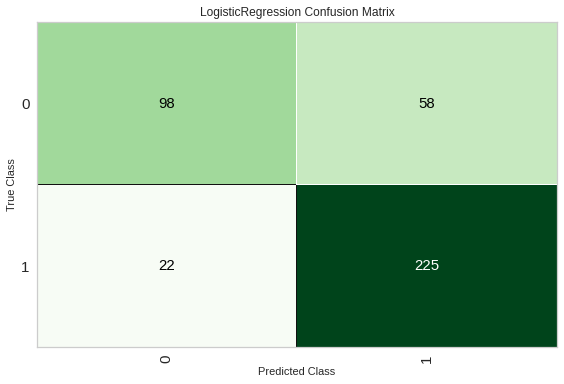

In [ ]:
plot_model(lr, plot='confusion_matrix')

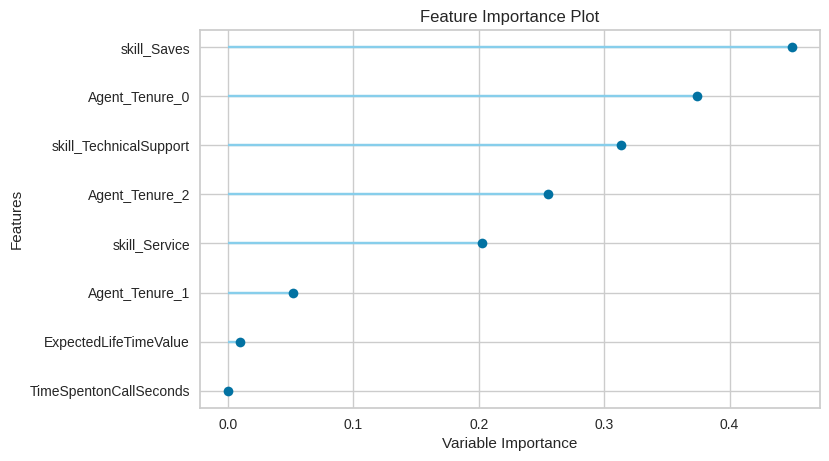

In [ ]:
plot_model(lr, plot='feature')

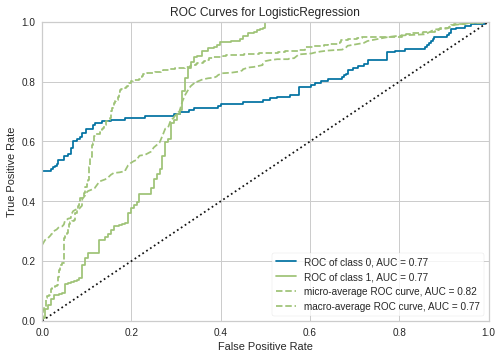

In [ ]:
plot_model(lr)